In [85]:
import pandas as pd

In [86]:
import pickle
import sys
import os

# Add project root to sys.path
sys.path.append(os.path.abspath(os.path.join("../..")))  # if you're in optimizer/

with open("../parameters/simulation_parameters.pkl", "rb") as f:
    sim_params = pickle.load(f)

simulated_logs = pd.read_csv("../../simulated_log.csv")

In [87]:
simulated_logs[simulated_logs['agent']==0]

,case_id,agent,activity,start,end
5,0,0,Check application form completeness,2023-04-20 09:22:04.813239287+00:00,2023-04-20 09:35:02.986694610+00:00
6,0,0,Check credit history,2023-04-20 09:35:02.986694610+00:00,2023-04-20 09:41:07.826727403+00:00
20,1,0,Check credit history,2023-04-20 10:29:57.758389087+00:00,2023-04-20 11:16:42.106236238+00:00
44,2,0,Cancel application,2023-04-21 07:20:00+00:00,2023-04-21 07:25:00+00:00
60,4,0,Check application form completeness,2023-04-21 07:25:00+00:00,2023-04-21 07:51:38.910352314+00:00
76,6,0,Check credit history,2023-04-20 11:16:42.106236238+00:00,2023-04-20 11:57:38.485158873+00:00
80,6,0,Check application form completeness,2023-04-20 14:27:51.971989522+00:00,2023-04-20 14:34:54.616450521+00:00
93,7,0,Check credit history,2023-04-20 12:08:41.688644565+00:00,2023-04-20 12:57:56.759335475+00:00
101,8,0,Check credit history,2023-04-20 13:10:47.980685956+00:00,2023-04-20 13:17:58.525291128+00:00


In [88]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_agent_timeline_by_case(df, agent_id):
    """
    Plots a Gantt-style timeline for a given agent,
    showing when they were busy and for which case.
    """

    df = df.copy()
    df['start'] = pd.to_datetime(df['start'], format='mixed', utc=True)
    df['end'] = pd.to_datetime(df['end'], format='mixed', utc=True)
    df = df[df['agent'] == agent_id].sort_values('start')

    # Map case_id to y-axis positions
    case_ids = df['case_id'].unique()
    case_to_y = {case: i for i, case in enumerate(case_ids)}

    fig, ax = plt.subplots(figsize=(14, len(case_ids) * 0.4 + 2))

    for _, row in df.iterrows():
        y = case_to_y[row['case_id']]
        ax.plot([row['start'], row['end']], [y, y], linewidth=8, label=f"Case {row['case_id']}", alpha=0.7)

    ax.set_yticks(list(case_to_y.values()))
    ax.set_yticklabels([f"Case {c}" for c in case_ids])
    ax.set_xlabel("Time")
    ax.set_title(f"Agent {agent_id} Activity Timeline by Case")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))

    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [89]:
simulated_logs[(simulated_logs['agent']==8)].sort_values(by='start')

,case_id,agent,activity,start,end
18,1,8,Check application form completeness,2023-04-20 09:42:04.813239287+00:00,2023-04-20 10:00:56.388632277+00:00
70,5,8,Check credit history,2023-04-20 10:35:02.309591563+00:00,2023-04-20 11:21:56.577306984+00:00
56,4,8,Check credit history,2023-04-20 11:53:53.298412973+00:00,2023-04-20 12:02:19.077081356+00:00
12,0,8,Reject application,2023-04-20 12:43:14.008318268+00:00,2023-04-20 12:53:14.008318268+00:00
26,1,8,Check credit history,2023-04-20 13:57:34.109263691+00:00,2023-04-20 14:02:19.522451703+00:00
66,4,8,Check credit history,2023-04-21 09:03:01.510985201+00:00,2023-04-21 09:11:42.651684186+00:00


In [90]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.cm as cm

def plot_agent_timeline_by_case(df, agent_id):
    df = df.copy()
    df['start'] = pd.to_datetime(df['start'], format='mixed', utc=True)
    df['end'] = pd.to_datetime(df['end'], format='mixed', utc=True)
    df = df[df['agent'] == agent_id].sort_values('start')

    case_ids = df['case_id'].unique()
    activity_types = df['activity'].unique()

    cmap = cm.get_cmap('tab20', len(activity_types))
    activity_to_color = {act: cmap(i) for i, act in enumerate(activity_types)}
    case_to_y = {case: i for i, case in enumerate(case_ids)}

    fig, ax = plt.subplots(figsize=(14, len(case_ids) * 0.4 + 2))

    for _, row in df.iterrows():
        y = case_to_y[row['case_id']]
        color = activity_to_color[row['activity']]
        ax.hlines(y, xmin=row['start'], xmax=row['end'],
                  linewidth=6, color=color, alpha=0.9)

    ax.set_yticks(list(case_to_y.values()))
    ax.set_yticklabels([f"Case {cid}" for cid in case_ids])
    ax.set_xlabel("Time")
    ax.set_title(f"Agent {agent_id} Activity Timeline by Case")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Add legend
    handles = [plt.Line2D([0], [0], color=color, lw=6) for color in activity_to_color.values()]
    labels = list(activity_to_color.keys())
    ax.legend(handles, labels, title="Activity", bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [91]:
simulated_logs['activity'].unique()

array(['Check application form completeness', 'Check credit history',
       'AML check', 'Appraise property', 'Assess loan risk',
       'Reject application', 'Design loan offer', 'Approve loan offer',
       'Approve application', 'Cancel application'], dtype=object)

/var/folders/x3/5rg2fq097snf05l9glzskh9r0000gn/T/ipykernel_18652/731271094.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(activity_types))


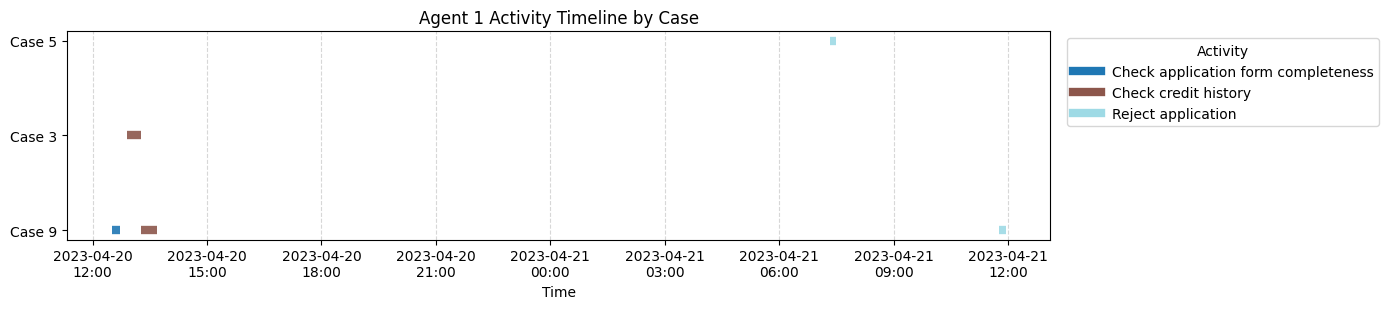

In [115]:
plot_agent_timeline_by_case(simulated_logs, agent_id=1)

In [93]:
simulated_logs[(simulated_logs['agent']==3) & (simulated_logs['case_id'].isin([4,5]))].sort_values(by='start')

,case_id,agent,activity,start,end
71,5,3,Appraise property,2023-04-20 12:33:32.534003751+00:00,2023-04-20 12:49:36.208490826+00:00


/var/folders/x3/5rg2fq097snf05l9glzskh9r0000gn/T/ipykernel_18652/731271094.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(activity_types))


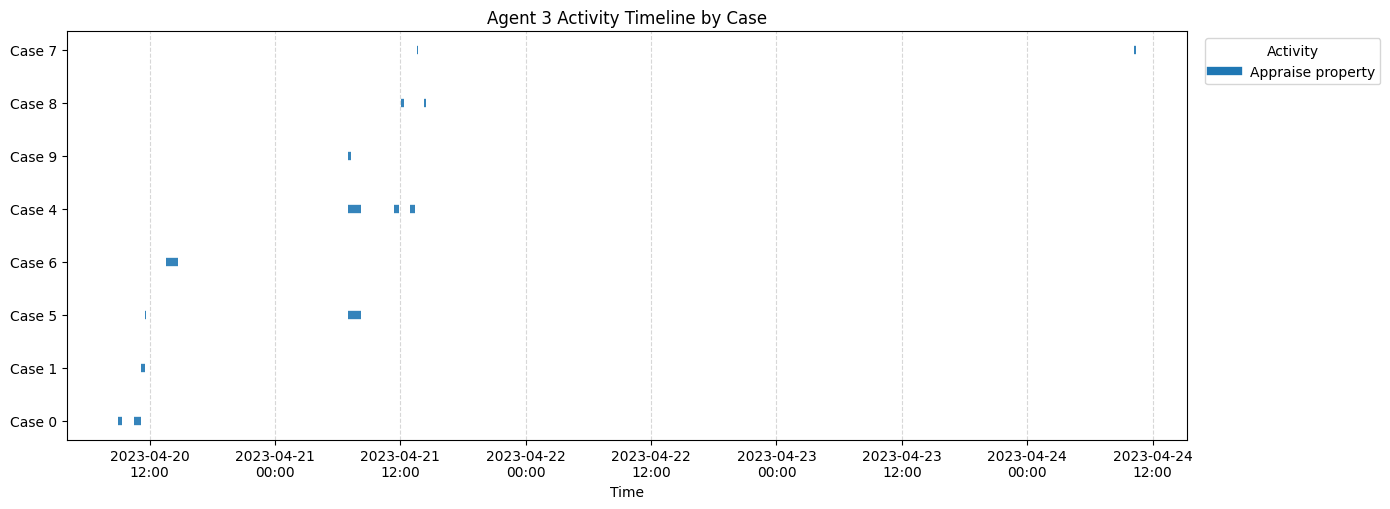

In [ ]:
plot_agent_timeline_by_case(simulated_logs, agent_id=3) #bug: when shifting time forward we do not check for concurency/available windows


In [65]:
simulated_logs[(simulated_logs['agent']==3) & (simulated_logs['case_id'].isin([4,5]))].sort_values(by='start')

,case_id,agent,activity,start,end
92,5,3,Appraise property,2023-04-20 11:32:34.506367367+00:00,2023-04-20 11:41:53.782396106+00:00
71,4,3,Appraise property,2023-04-21 07:00:00+00:00,2023-04-21 08:16:19.904269872+00:00
99,5,3,Appraise property,2023-04-21 07:00:00+00:00,2023-04-21 08:13:51.922067673+00:00
79,4,3,Appraise property,2023-04-21 11:24:07.315051775+00:00,2023-04-21 11:53:40.019519537+00:00
83,4,3,Appraise property,2023-04-21 12:54:13.852778058+00:00,2023-04-21 13:26:45.317364179+00:00


In [ ]:
simulated_logs[simulated_logs['case_id']==5]


,case_id,agent,activity,start,end
89,5,9,Check application form completeness,2023-04-20 10:30:00+00:00,2023-04-20 10:31:08.593858282+00:00
90,5,10,Check credit history,2023-04-20 10:49:08.656148901+00:00,2023-04-20 10:57:36.806992279+00:00
91,5,7,AML check,2023-04-20 10:57:36.806992279+00:00,2023-04-20 11:31:20.042476131+00:00
92,5,3,Appraise property,2023-04-20 11:32:34.506367367+00:00,2023-04-20 11:41:53.782396106+00:00
93,5,13,Assess loan risk,2023-04-20 11:41:53.782396106+00:00,2023-04-20 12:01:53.782396106+00:00
94,5,11,Design loan offer,2023-04-20 12:14:27.917392986+00:00,2023-04-20 12:14:45.230800505+00:00
95,5,17,Approve loan offer,2023-04-20 12:14:45.230800505+00:00,2023-04-20 12:34:45.230800505+00:00
96,5,4,Check application form completeness,2023-04-20 12:34:45.230800505+00:00,2023-04-20 12:42:37.933100593+00:00
97,5,10,Check credit history,2023-04-20 12:42:37.933100593+00:00,2023-04-20 13:15:54.794736902+00:00
98,5,2,AML check,2023-04-20 13:57:40.398120647+00:00,2023-04-20 14:46:39.739216778+00:00


In [31]:
sim_params['case_arrival_times'][7]

Timestamp('2023-04-20 11:30:00+0000', tz='UTC')

In [21]:
simulated_logs[(simulated_logs['agent']==1) & (simulated_logs['case_id'].isin([9,8]))]

,case_id,agent,activity,start,end
148,8,1,Check credit history,2023-04-21 10:22:49.794170449+00:00,2023-04-21 11:43:48.443974799+00:00
163,8,1,Check application form completeness,2023-04-24 10:11:15.240656487+00:00,2023-04-24 10:17:26.835576432+00:00
179,9,1,Check credit history,2023-04-21 09:46:48.090138394+00:00,2023-04-21 10:22:27.711467937+00:00
